In [1]:
import os
import urllib
from pathlib import Path

import numpy as np
import numpy.linalg as LA
import spiceypy as spice
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
from surrender.geometry import vec3, vec4, MatToQuat, gaussian
from surrender.surrender_client import surrender_client

from craterdetection.matching.database import extract_robbins_dataset, load_craters
from craterdetection.matching.projective_invariants import crater_representation, matrix_adjugate

_BASE_URL = 'https://naif.jpl.nasa.gov/pub/naif/'
_KERNEL_ROOT = Path('../data/spice_kernels')

# Constants:
sun_radius = 696342000
ua2km = 149597870.700
ua = ua2km * 1e3
R_moon = 1737.4

In [2]:
def download_kernel(file_path, base_url=_BASE_URL, base_folder=_KERNEL_ROOT):
    if isinstance(file_path, str):
        file_path = Path(file_path)

    local_path = base_folder / file_path
    url = base_url + file_path.as_posix()

    # Create necessary sub-directories in the DL_PATH direction
    local_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        # If the file is not present in the download directory -> download it
        if not os.path.isfile(local_path):
            print(f"Downloading {url}", end="  ")
            # Download the file with the urllib  package
            urllib.request.urlretrieve(str(url), str(local_path))
            print("Done.")
        else:
            print(f"{base_folder / file_path} already exists!")
    except urllib.error.HTTPError as e:
        print(f"Error: \n{url} could not be found: ", e)

In [3]:
kernels = list(map(Path, [
    'generic_kernels/lsk/naif0012.tls',
    'generic_kernels/pck/pck00010.tpc',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/spk/de421.bsp',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/pck/moon_pa_de421_1900_2050.bpc',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_assoc_pa.tf',
    'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_080317.tf'
]))

In [4]:
for k in kernels:
    download_kernel(k)

spice.furnsh(map(str, list(map(lambda x: _KERNEL_ROOT / x, kernels))))

..\data\spice_kernels\generic_kernels\lsk\naif0012.tls already exists!
..\data\spice_kernels\generic_kernels\pck\pck00010.tpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\spk\de421.bsp already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\pck\moon_pa_de421_1900_2050.bpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_assoc_pa.tf already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_080317.tf already exists!


In [5]:
# Image setup:
fov = 45
raytracing = False
N = [1000, 1000]
rays = 64

# set PSF
surech_PSF = 5
sigma = 1
wPSF = 5
PSF = gaussian(wPSF * surech_PSF, sigma * surech_PSF)

## Initializing SurRender
s = surrender_client()
s.setVerbosityLevel(2)
s.connectToServer('127.0.0.1')
s.setCompressionLevel(0)
s.closeViewer()
s.setTimeOut(86400)
s.setShadowMapSize(4096)
s.setCubeMapSize(4096)
s.enableMultilateralFiltering(True)
s.enablePreviewMode(True)
s.enableDoublePrecisionMode(True)
s.enableRaytracing(raytracing)
s.setConventions(s.SCALAR_XYZ_CONVENTION, s.Z_FRONTWARD)
s.setPSF(PSF, wPSF, wPSF)

if raytracing:
    s.enableFastPSFMode(False)
    s.enableRaytracing(True)
    s.enableIrradianceMode(False)
    s.setNbSamplesPerPixel(rays)  # Raytracing
    s.enableRegularPSFSampling(True)
    s.enablePathTracing(False)
else:
    s.enableFastPSFMode(True)
    s.enableRaytracing(False)
    s.enableIrradianceMode(False)
    s.enablePathTracing(False)

s.createBRDF('sun', 'sun.brdf', {})
s.createShape('sun', 'sphere.shp', {'radius': sun_radius})
s.createBody('sun', 'sun', 'sun', [])

s.createBRDF('hapke', 'hapke.brdf', {})
s.createSphericalDEM('moon', 'Moon_LRO.dem', 'hapke', 'lroc_color_poles.tiff')
s.setObjectElementBRDF('moon', 'moon', 'hapke')

s.setCameraFOVDeg(fov, np.arctan(np.tan(fov / 360 * np.pi) * N[1] / N[0]) * 360 / np.pi)
s.setImageSize(N[0], N[1])

s.setSunPower( ua * ua * np.pi * vec4(1, 1, 1, 1))

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [6]:
# convert the datetime to a string, replacing the time with midnight
DATE = '2020-12-15T00:00:00'

# convert the utc midnight string to the corresponding ET
ET_DATE = spice.utc2et(DATE)

In [9]:
MOON_POS = vec3(0, 0, 0)

SUN_POS_REL_MOON, _ = spice.spkpos(targ='SUN', et=ET_DATE, ref='MOON_PA', abcorr='NONE', obs='MOON')
SUN_POS_REL_MOON *= 1e3  # Convert to m

EARTH_POS_REL_MOON, _ = spice.spkpos(targ='EARTH', et=ET_DATE, ref='MOON_PA', abcorr='NONE', obs='MOON')
EARTH_POS_REL_MOON *= 1e3  # Convert to m

dist = R_moon*1e3 + 3000e3

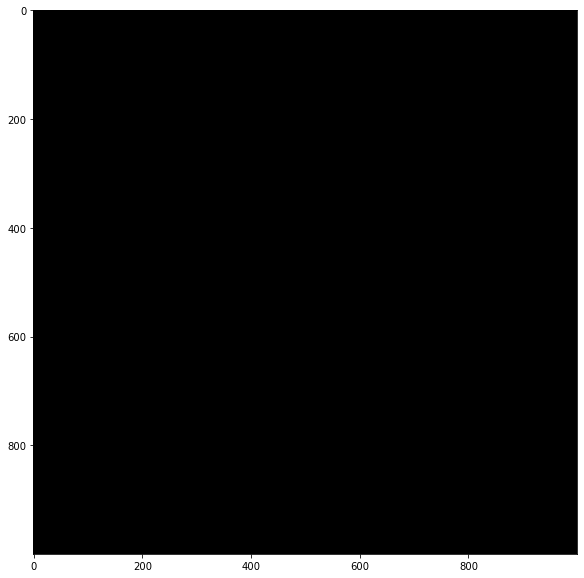

In [42]:
### ROTATE CAMERA
k = np.array([0., 0., 1.])[:, None]
pos_cam = np.array([0, dist, 0])

Z_cam = -pos_cam / LA.norm(pos_cam)

X_cam = np.cross(k, Z_cam, axis=0)
X_cam /= LA.norm(X_cam, ord=2)

Y_cam = np.cross(Z_cam, X_cam, axis=0)
Y_cam /= LA.norm(Y_cam, ord=2)

T_CM = np.concatenate((X_cam, Y_cam, Z_cam[:, None]), axis=-1)
T_MC = LA.inv(T_CM)

s.setObjectPosition('camera', pos_cam)
s.setObjectAttitude('camera', MatToQuat(T_MC))
s.setObjectPosition('sun', tuple(SUN_POS_REL_MOON))
s.setObjectPosition('moon', MOON_POS)

# s.setObjectAttitude('moon', R.from_euler('x', 240, degrees=True).as_quat())

s.render()
im = s.getImageGray32F()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, aspect='equal', interpolation='none', cmap='gray')

### Mathematical Representation of a Crater
Pages 20 - 25 from [Christian, J. A., Derksen, H., & Watkins, R. (2020). Lunar Crater Identification in Digital Images](http://arxiv.org/abs/2009.01228)

#### Convert coordinates to 3D selenographic position
`load_robbins_dataset` extracts all craters with the given parameters and returns their lat, long, psi (angle) in radians, and
major and minor axis in km.
Filter dataset using latitude & longitude limits using `latlims` and `longlims` parameters.

3D selenographic position is determined using their latitude $\varphi$ & longitude $\lambda$ along with distance
from center $\rho$:

$\rho_i \begin{bmatrix}
\cos\varphi_i\cos\lambda_i \\
\cos\varphi_i\sin\lambda_i \\
\sin\varphi_i
\end{bmatrix}$,

In [35]:
# The following extracts all craters with the given parameters and returns their lat, long, psi (angle) in radians, and
# major and minor axis in km.
lat, long, major, minor, psi, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[200, 350])
)

p_Mi = R_moon*np.array([
    np.cos(lat)*np.cos(long),
    np.cos(lat)*np.sin(long),
    np.sin(lat)
]).T[..., None]
T_MC

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [-0., -1., -0.]])

#### Define local ENU coordinate system per crater
$ \mathbf{u}_i = \frac{\mathbf{p}^{(c)}_{M_i}}{||\mathbf{p}^{(c)}_{M_i}||} $,
$ \mathbf{e}_i = \frac{\mathbf{k} \times \mathbf{u}_i}{|| \mathbf{k} \times \mathbf{u}_i ||} $,
$ \mathbf{n}_i = \frac{\mathbf{u}_i \times \mathbf{e}_i}{|| \mathbf{u}_i \times \mathbf{e}_i ||} $,

with $ k = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}^T $,

results in attitude transformation matrix

$ T^{E_i}_M = \begin{bmatrix} \mathbf{e}_i & \mathbf{n}_i & \mathbf{u}_i \end{bmatrix} $

In [36]:
k = np.array([0, 0, 1])[:, None]

u_i = p_Mi / R_moon

e_i = np.cross(k[None, ...], u_i, axis=1)
e_i /= LA.norm(e_i, ord=2, axis=(1,2))[:, None, None]

n_i = np.cross(u_i, e_i, axis=1)
n_i /= LA.norm(n_i, ord=2, axis=(1,2))[:, None, None]

T_EM = np.concatenate((e_i, n_i, u_i), axis=-1)

#### Define relation between point in 2D ellipse plane and 3D selenographic frame

$ H_{M_i} = \begin{bmatrix}
             T^{E_i}_M \mathbf{S} &  \mathbf{p}^{(c)}_{M_i}
           \end{bmatrix} $

$ \mathbf{S} = \begin{bmatrix}
                    \mathbf{I}_{2\times2} \\
                    \mathbf{0}_{1\times2}
                \end{bmatrix}
$

In [37]:
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)
H_Mi = np.concatenate((T_EM @ S, p_Mi), axis=-1)

### Homography and Action of a Projective Camera on a Crater Disk Quadric

#### Define camera calibration matrix

The conversion between image plane coordinates ($\mathbf{\bar{x}}_C$) and digital image pixel coordinates
($\mathbf{\bar{u}}_C$) is described the following affine transformation:

$ \mathbf{K} = \begin{bmatrix}
    d_x & \alpha & u_p \\
    0   & d_y    & v_p \\
    0   & 0      & 1
\end{bmatrix} $,

$ \mathbf{\bar{u}}_C = \mathbf{K} \mathbf{\bar{x}}_C$

In [38]:
f_x = (N[0]/2) / np.tan(np.radians(fov)/2)
f_y = (N[1]/2) / np.tan(np.radians(fov)/2)

K = np.array([[f_x, 0,       N[0]/2],
             [0,    f_y,     N[1]/2],
             [0,    0,       1]])

Using camera position in camera reference frame $C$  ($\mathbf{r }_C$) and the camera attitude $\mathbf{T}^M_C$ the camera projection matrix is as follows:

$ \mathbf{P}^M_C = \mathbf{K} \begin{bmatrix} \mathbf{T}^M_C & -r_C \end{bmatrix}$

With this, the homography to project the crater's disk quadric into its apparent ellipse in the image plane is found:

$ \mathbf{H}_{C_i} =  \mathbf{P}^M_C \begin{bmatrix}H_{M_i} \\ k^T \end{bmatrix} $

Using the [matrix representation of an ellipse](https://en.wikipedia.org/wiki/Matrix_representation_of_conic_sections)
the ellipse in the local crater plane $\mathbf{C}_i$ can be transformed to the image plane:

$ \mathbf{A_i} \propto \mathbf{H}_{C_i}^{-T} \mathbf{C}_i \mathbf{H}_{C_i} $

In [39]:
r_M = pos_cam[:, None]/1e3
r_C = T_MC @ r_M
# P_MC = K @ np.concatenate((T_MC, -r_C), axis=1)
P_MC = K @ T_MC @ np.concatenate((np.identity(3), r_M), axis=1)
H_Ci = P_MC @ np.concatenate((H_Mi, np.tile(k.T[None, ...], (len(H_Mi), 1, 1))), axis=1)

C_i = crater_representation(0, 0, major, minor, psi)
A_i = (LA.inv(H_Ci.transpose(0, 2, 1)) @ C_i) @ LA.inv(H_Ci)

#### Overlay output onto render

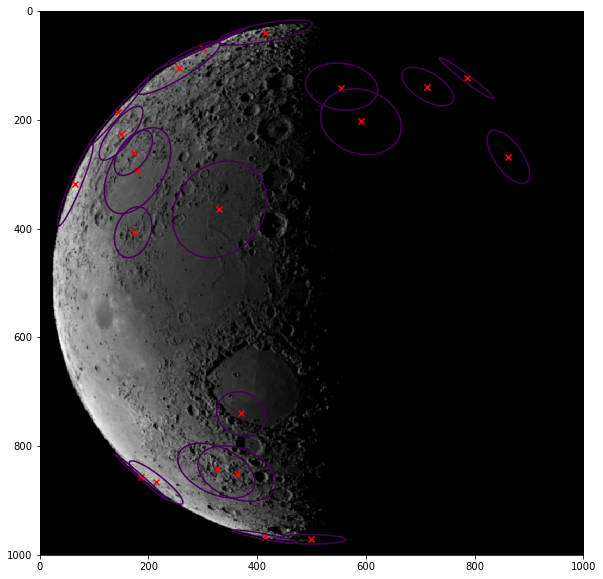

In [40]:
def ellipse_from_matrix(x, y, matrix):
    A_ = matrix[0, 0]
    C_ = matrix[1, 1]
    G_ = matrix[2, 2]
    B_ = 2*matrix[1, 0]
    D_ = 2*matrix[2, 0]
    F_ = 2*matrix[2, 1]
    return A_*(x**2) + B_*x*y + C_*(y**2) + D_*x + F_*y + G_
x_plot = np.linspace(0, N[0], 500)
y_plot = np.linspace(0, N[1], 500)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

crater_centers = (H_Ci @ np.array([0, 0, 1]) / (H_Ci @ np.array([0, 0, 1]))[:, -1][:, None])[:, :2]
# c = xy_homogeneous.transpose(0, 2, 1) @ A_i[:, None, ...] @ xy_homogeneous
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention
ax.set_xlim(0, 1000)
ax.set_ylim(1000, 0)
ax.imshow(im, aspect='equal', interpolation='none', cmap='gray')

for A_ii in A_i:
    ax.contour(x_plot, y_plot, ellipse_from_matrix(x_plot, y_plot, A_ii), [0])
ax.scatter(*crater_centers.T, c='r', marker='x')

#### Unused

In [798]:
planes = np.concatenate([u_i.transpose(0, 2, 1), -R_moon*np.ones((u_i.shape[0]))[:, None, None]], axis=-1)
C_star = matrix_adjugate(C_i)
x_quadric = np.concatenate((H_Mi, np.tile(k.T, (p_Mi.shape[0], 1, 1))), axis=1)
Q_star = x_quadric @ C_star @ x_quadric.transpose(0, 2, 1)
A_i_star = P_MC @ Q_star @ P_MC.T